Import the data from a text file and put it in a Pandas DataFrame

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt 

In [2]:
# Parse data from the text file
with open('boston_dataset.txt', 'r') as boston_housing_data_file:

    # Get rid of the text, concatenate every two lines
    boston_housing_data_text = []
    line_counter = 0
    for line in boston_housing_data_file.readlines():
        if (line_counter>21):
            if (line_counter%2 == 0):
                line_temp = line.split()
            else:
                line_temp = line_temp + line.split()
                boston_housing_data_text.append(line_temp)
        line_counter+=1
    # Convert into numbers and put into a np array
    # Populate the array initially
    boston_housing_data = np.zeros(14)
    for entry in boston_housing_data_text:
        entry_numbers = []
        for data in entry:
            # Convert every field into a number
            entry_numbers.append(float(data))
        # Append vertically
        boston_housing_data = np.vstack((boston_housing_data, entry_numbers))
    # Get rid of the initial zeros
    raw_dataset = boston_housing_data[1:, :]

# Put the data in a Pandas DataFrame
dataset = pd.DataFrame(data=raw_dataset, columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
print(dataset.tail())
                    

        CRIM   ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
501  0.06263  0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527  0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076  0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959  0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741  0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  MEDV  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9  


Split the data into train and test

In [3]:
# Randomly choose 80% of the dataset for training, use the rest for testing
train_dataset = dataset.sample(frac=0.8, random_state=1)
test_dataset = dataset.drop(train_dataset.index)

Inspect the data: have a quick look at the joint distribution of a few pairs of columns from the training set and look at the overall statistics.

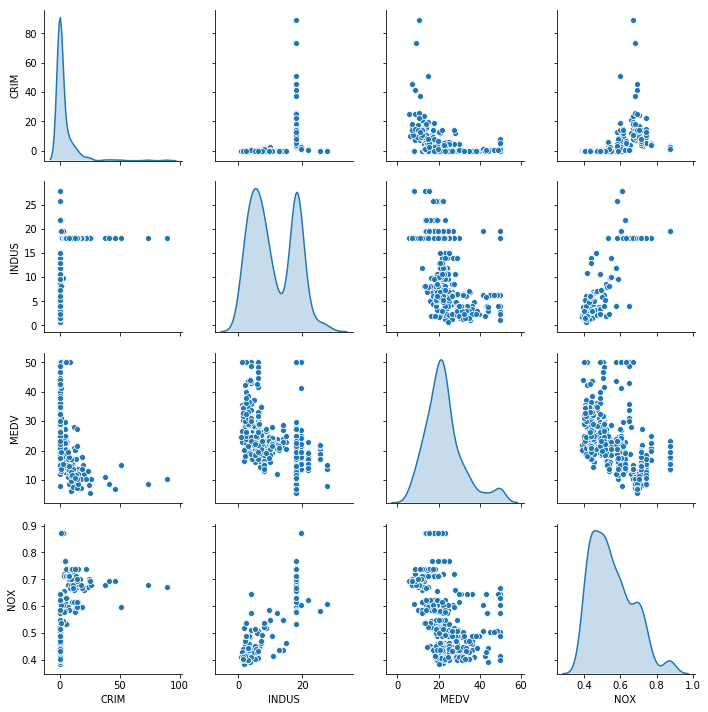

In [4]:
sns.pairplot(train_dataset[['CRIM', 'INDUS', 'MEDV', 'NOX']], diag_kind="kde")

In [5]:
# Generates descriptive statistics that summarize the central tendency, 
# dispersion and shape of a dataset's distribution, excluding NaN values
train_stats = train_dataset.describe()
train_stats.pop('MEDV')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,3.586927,8.515729,0.00632,0.08187,0.2498,3.67822,88.9762
ZN,405.0,11.646914,23.673496,0.00000,0.00000,0.0000,12.50000,100.0000
INDUS,405.0,11.023111,6.809215,0.74000,5.13000,8.5600,18.10000,27.7400
CHAS,405.0,0.069136,0.253999,0.00000,0.00000,0.0000,0.00000,1.0000
NOX,405.0,0.553760,0.114284,0.38500,0.45300,0.5320,0.62400,0.8710
RM,405.0,6.311086,0.697648,3.56100,5.89800,6.2450,6.63000,8.7800
AGE,405.0,68.358765,28.189729,2.90000,42.80000,76.9000,94.10000,100.0000
DIS,405.0,3.783288,2.093565,1.12960,2.10690,3.1827,5.11670,12.1265
RAD,405.0,9.617284,8.751475,1.00000,4.00000,5.0000,24.00000,24.0000
TAX,405.0,409.056790,168.128264,187.00000,279.00000,334.0000,666.00000,711.0000


In [6]:
# Split features from labels
train_labels = train_dataset.pop('MEDV')
test_labels = test_dataset.pop('MEDV')
# Make sure the labels are treated as 2d arrays that can be fed into placeholder for Y
# Transpose to keep the 'vertical' shape
train_labels = np.transpose(np.atleast_2d(train_labels))
test_labels = np.transpose(np.atleast_2d(test_labels))

In [7]:
# Normalize the data using mean and standard deviation - intentionally use stats
# from only the training set, these statistics will aslo be used for evaluation.
# This is so that the model doesn't have any information about the test set.
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [8]:
# Insert a column with constant value for the constant parameter in linear regression
normed_train_data.insert(0, column='CONST', value=1)
normed_test_data.insert(0, column='CONST', value=1)

In [9]:
n_dim = normed_train_data.shape
n_dim

(405, 14)

In [10]:
learning_rate = 0.01
training_epochs = 1000
cost_history = np.empty(shape=[1], dtype=float)

X = tf.placeholder(tf.float32, [None, n_dim[1]])
Y = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.ones([n_dim[1] ,1]))

init = tf.global_variables_initializer()

In [11]:
# Multiply features matrix to weights matrix and can be used for prediction
y_ = tf.matmul(X, W)
# Define the cost function - squared error of regression line
cost = tf.reduce_mean(tf.square(y_-Y))
# Perform one step of gradient descent optimisation to minimise the cost fucntion
training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [12]:
# Training of the linear regression model
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    sess.run(training_step, feed_dict={X:normed_train_data,Y:train_labels})
    cost_history = np.append(cost_history,sess.run(cost,feed_dict={X:normed_train_data,Y:train_labels}))
    

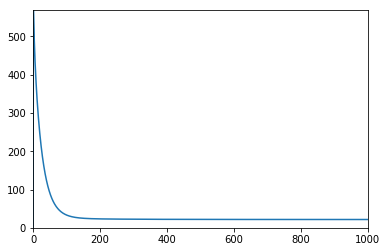

In [13]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 95.1029


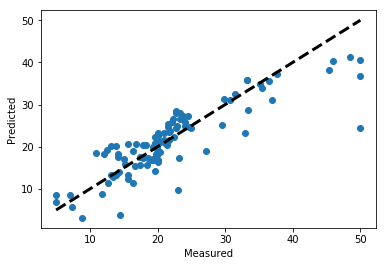

In [14]:
pred_y = sess.run(y_, feed_dict={X:normed_test_data})
pred_y_train = sess.run(y_, feed_dict={X:normed_train_data})
mse = tf.reduce_mean(tf.square(pred_y[0] - test_labels))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(test_labels, pred_y)
ax.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [15]:
sess.close()